# Hands-On With TA Data Kit and Wrap Up

## 8. Hands-On Exercise: Kinetics from DSC Multiple Measurements

We'll now analyse some DSC data using what we've learnt.

### Listing files

Let's start by listing all JSON files in the DSC kinetics folder.

In [ ]:
import os

directory = "files/DSC kinetics/"
dsc_files = []
for file in os.listdir(directory):
    if file.endswith(".json"):
        dsc_files.append(directory + file)

dsc_files

### Importing TA Data Kit

TA Data Kit can be installed with `pip install tadatakit`, here it's already available for you. We'll import the `Experiment` class from it and load a file.

In [ ]:
from tadatakit.classes import Experiment

Experiment?

In [ ]:
Experiment.from_json?

In [ ]:
experiment = Experiment.from_json(dsc_files[0])

In [ ]:
experiment.operators

In [ ]:
experiment.get_dataframe?

In [ ]:
df = experiment.get_dataframe("processed")
df

In [ ]:
_ = df.plot("Temperature / °C", "Heat Flow (Normalized) / W/g", figsize=(10,6))

In [ ]:
print(f"Peak heat flow occured at {df.loc[df['Heat Flow (Normalized) / W/g'].idxmax(), 'Temperature / °C']:.1f} °C")

### Loading all files

We'll load the data from all experiments in the study and organize it by the heating rate of each.

In [ ]:
experiments = {}

for file_path in dsc_files:
    experiment = Experiment.from_json(file_path)
    print(f"{file_path} loaded")
    heating_rate = float(experiment.procedure.steps[1].name.replace("Ramp ", "").split()[0])
    experiments[heating_rate] = experiment

# Extract processed data frames for each experiment
data_frames = {rate: exp.get_dataframe("processed") for rate, exp in sorted(experiments.items())}

### Plotting all of the data together

In [ ]:
# Import matplotlib
import matplotlib.pyplot as plt

# Set up a figure
plt.figure(figsize=(10,6))
# Grab the current axes as `ax`
ax = plt.axes()
# Create list to collect labels to add to the legend
labels = []
# Loop through our datasets
for heating_rate, df in data_frames.items():
    # Use pandas built in plotting capability to plot each dataset on the same axes
    df.plot.line(x="Temperature / °C", y="Heat Flow (Normalized) / W/g", ax=ax)
    labels.append(f"{int(heating_rate)}°C/min")
plt.ylabel("Heat Flow (Normalized) / W/g")
_ = ax.legend(labels)

plt.show()

### Defining Data Processing Functions

Now let's get a little fancier by defining a few functions to help us analyze the DSC data, such as finding peaks, calculating enthalpy, and processing data segments. Note that this is just defining them, not running them yet.

In [ ]:
# import numpy
import numpy as np

def find_peak(data):
    """Find the peak of the DSC curve."""
    return data['Heat Flow (Normalized) / W/g'].idxmax()

def calculate_enthalpy(data, start_idx, end_idx):
    """Calculate the enthalpy by integrating the area under the curve."""
    segment = data.iloc[start_idx:end_idx]
    return np.trapz(segment['Heat Flow (Normalized) / W/g'], segment['Time / min'] * 60)

def process_data(data, start_temp, end_temp):
    """Extract data for a specific temperature range and calculate properties."""
    filtered_data = data[(data['Temperature / °C'] >= start_temp) & (data['Temperature / °C'] <= end_temp)]
    # use the find peak method from above on the data range
    peak_idx = find_peak(filtered_data)
    # calculate the enthalpy of the found peak using the calculate_enthalpy function above
    enthalpy = calculate_enthalpy(data, 0, peak_idx)
    return enthalpy, filtered_data

### Calculating Enthalpy and Visualizing Data

Now we can apply these functions to each experiment.

In [ ]:
plt.figure(figsize=(10, 6))

for rate, df in data_frames.items():
    enthalpy, segment = process_data(df, 30, 300)
    # this time I'm using matplotlib's approach to plotting
    plt.plot(df['Temperature / °C'], df['Heat Flow (Normalized) / W/g'], label=f"{rate:.0f} °C/min")
    plt.fill_between(segment['Temperature / °C'], segment['Heat Flow (Normalized) / W/g'], alpha=0.3, label=f"Enthalpy = {enthalpy:.2f} J/g")

plt.xlabel("Temperature (°C)")
plt.ylabel("Heat Flow (Normalized) (W/g)")
plt.legend()
plt.title("DSC Curves and Calculated Enthalpy")
plt.show()

### Activation Energy Calculation

Let's define another function to extract 1 / peak temperature and log heating rate.

In [ ]:
def process_for_kinetics(data, start_temp, end_temp, heating_rate):
    """Extract peak temps."""
    segment = data[(data['Temperature / °C'] >= start_temp) & (data['Temperature / °C'] <= end_temp)]
    temperature = segment["Temperature / °C"]
    time_seconds = segment["Time / min"] * 60
    heat_flow = segment["Heat Flow (Normalized) / W/g"]
    baseline = np.interp(
        temperature,
        [temperature.iloc[0], temperature.iloc[-1]],
        [heat_flow.iloc[0], heat_flow.iloc[-1]],
    )
    normalized_heat_flow = heat_flow - baseline
    time_normalized = (time_seconds - time_seconds.iloc[0]) / 60
    cumulative_heat_flow = normalized_heat_flow.cumsum() / normalized_heat_flow.sum()
    derivative = np.gradient(cumulative_heat_flow, time_normalized)
    peak_temperature = temperature.iloc[np.argmax(derivative)]
    inverse_peak_temperature = 1 / (peak_temperature + 273.15)
    log_heating_rate = np.log(heating_rate)
    return inverse_peak_temperature, log_heating_rate

We can then apply that to each one.

In [ ]:
arrhenius_data = []
for rate, df in data_frames.items():
    inverse_peak_temperature, log_heating_rate = process_for_kinetics(df, 30, 250, rate)
    arrhenius_data.append({
        "Inverse Peak Temp / 1/K": inverse_peak_temperature,
        "Log Heating Rate / ln(°C/min)": log_heating_rate
    })

import pandas as pd

arrhenius_data = pd.DataFrame(arrhenius_data)
arrhenius_data

Finally, we can plot the Arrhenius plot with the calculated data.

In [ ]:
# Perform linear regression
slope, intercept = np.polyfit(
    arrhenius_data["Inverse Peak Temp / 1/K"],
    arrhenius_data["Log Heating Rate / ln(°C/min)"],
    1,
)

# Plot it
fig = plt.figure(figsize=(10, 6))
plt.scatter(
    x=arrhenius_data["Inverse Peak Temp / 1/K"],
    y=arrhenius_data["Log Heating Rate / ln(°C/min)"],
)

# Calculate activation energy
activation_energy = -slope * 8.314

# Plot linear regression
arrhenius_fit_x = np.array(
    [
        arrhenius_data["Inverse Peak Temp / 1/K"].min(),
        arrhenius_data["Inverse Peak Temp / 1/K"].max(),
    ]
)
arrhenius_fit_y = slope * arrhenius_fit_x + intercept
plt.plot(arrhenius_fit_x, arrhenius_fit_y)

# Add some text
plt.text(x=0.00265, y=1.3, s=f"Activation Energy = {activation_energy/1000:.2f} kJ/mol", fontsize=12)

plt.xlabel("Inverse Peak Temp / 1/K")
plt.ylabel("Log Heating Rate / ln(°C/min)")
plt.show()

## Wrap-Up: TRIOS JSON Export and Python Training

### Key Concepts Reviewed

1. **Python Basics**: You've learned Python syntax, data types, and basic programming constructs like loops and conditional statements.
2. **JupyterLab**: You've become familiar with using JupyterLab, which will be a powerful tool in your data analysis toolkit.
3. **Scientific Libraries**: We explored NumPy for numerical operations and Pandas for data manipulation—essential libraries in Python's ecosystem for data science.
4. **Data Visualization**: Using Matplotlib, you've learned how to create various types of plots to visually interpret data.
5. **JSON Data Handling**: We discussed the structure of JSON data and how to parse it with Python, which is crucial for handling TRIOS exports.
6. **TA Data Kit**: You've had hands-on experience with the TA Data Kit, understanding its capabilities to manipulate and analyze experiment data.

### JSON Export Resources

1. **[Tech Tip Video](https://www.tainstruments.com/trios-json-export/)** - featuring our very own Jeff Marvin!
2. **[TA Data Kit on Github](https://github.com/TA-Instruments/tadatakit)** - featuring documentation and [real examples](https://github.com/TA-Instruments/tadatakit/blob/main/examples/README.md)
3. **[JSON Export Cheat Sheet](https://waterscorp.sharepoint.com/:b:/r/sites/TAInstrumentsTechnicalLibrary/Sales%20Books/Software/Product%20Presentations/TRIOS%20JSON%20Export%20Cheat%20Sheet.pdf?csf=1&web=1&e=QF2wb8)** - see below
4. **[TRIOS JSON Schema](https://software.tainstruments.com/schemas/TRIOSJSONExportSchema)** - very technical

### Python Resources

To continue your journey in Python programming and data analysis, here are some recommended resources:

- **[Learn Python](https://www.learnpython.org/)**: An interactive Python tutorial for beginners.
- **[Real Python](https://realpython.com/)**: Offers tutorials and articles for Python developers of all levels.
- **[DataCamp](https://www.datacamp.com/)**: Provides online courses and tracks in Python for data science.
- **[Kaggle](https://www.kaggle.com/learn)**: Learn hands-on data science and machine learning with mini-courses on topics like Pandas, machine learning, and more.
- **[Stack Overflow](https://stackoverflow.com/)**: A valuable resource for troubleshooting and learning from other developers' experiences.
- **[GitHub](https://github.com/)**: Explore open source projects and collaborate with the community. You can also review and contribute to the [TA Data Kit repository](https://github.com/TA-Instruments/tadatakit).
- **[Python Data Science Handbook](https://jakevdp.github.io/PythonDataScienceHandbook/)**: A complete guide to using Python for data analysis and visualization.

### Next Steps

If this has caught your interest, I would recommend:

- **Practicing**: Continue experimenting with the Jupyter Notebooks we’ve worked on and by cloning the ones on [github](https://github.com/TA-Instruments/tadatakit). Try modifying the code or applying the concepts to different datasets.
- **Collaborating**: Work with your colleagues on upcoming projects and apply your new skills to solve real-world problems.
- **Exploring**: Consider learning more about machine learning, which can be powerful for predictive analytics in materials science.
- **Contributing**: Figured out how to do something cool with our data? Consider publishing it as part of TA Data Kit to benefit our customers.

### The JSON Export Cheat Sheet

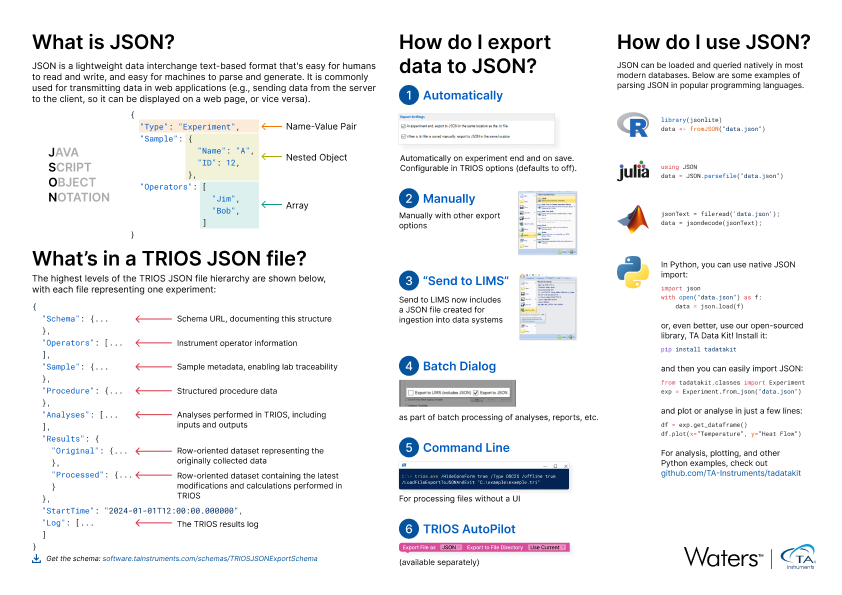

[Available here](https://waterscorp.sharepoint.com/:b:/r/sites/TAInstrumentsTechnicalLibrary/Sales%20Books/Software/Product%20Presentations/TRIOS%20JSON%20Export%20Cheat%20Sheet.pdf?csf=1&web=1&e=QF2wb8).